In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

from glob import glob
import nia22

from nia22 import eyes

In [3]:
base = "../../data/IR2RGB/"
device = "Monitor"
itype = ['ir', 'rgb'][1]
fn_img  = base+f"{device}/image/NIA22EYE_S1_087_T1_S09_M_{itype}_A_S_T_011.png"

fn_json = glob(fn_img.replace("/image/", "/json/")+"*.json")[0]
#fn_json = base+f"{device}/json/NIA22EYE_S1_087_T1_S09_M_{itype}_A_S_T_011.png_2475192.json"
jj = json.load(open(fn_json))

In [4]:
# load json
eye = nia22.eyes.Eye(jj['annotations'])

In [5]:
eye.l_center

{'key': 4,
 'label': 'l_center',
 'labelNum': 0,
 'points': [[883, 259]],
 'shape': 'Point',
 'type': 'Normal_Object'}

In [6]:
# load image
img = Image.open(fn_img)

In [82]:
eyes.plot_eyes(img, eye, fn='whole.png')

In [24]:
# crop face
region, cropped = eyes.crop_eye(np.array(img), eye.l_eyelid)

In [29]:
from nia22.eyes import mask_one_eye, crop_eye

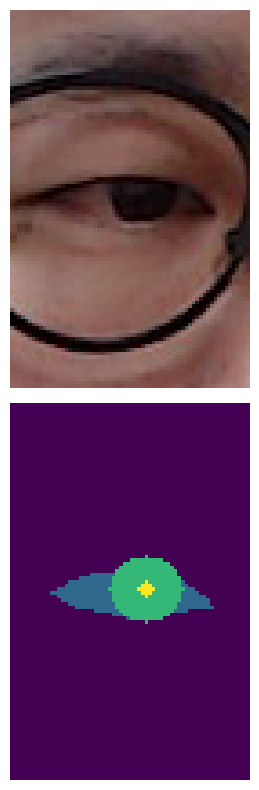

In [51]:
cropped, mask = mask_one_eye(np.array(img), eye, "l")
fig, axs = plt.subplots(2,1, figsize=(3,8))
axs[0].imshow(cropped)
axs[1].imshow(mask)
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.savefig("left_eye_mask.png")

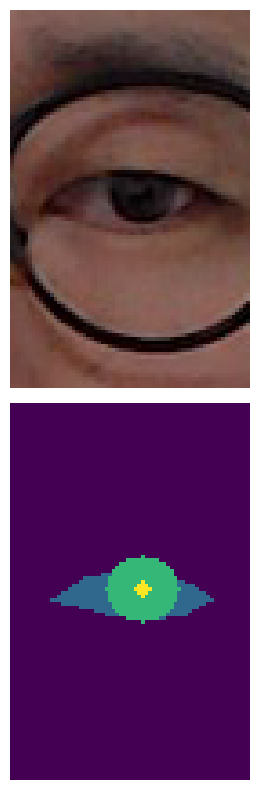

In [54]:
cropped, mask = mask_one_eye(np.array(img), eye, "r")
fig, axs = plt.subplots(2,1, figsize=(3,8))
axs[0].imshow(cropped)
axs[1].imshow(mask)
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.savefig("right_eye_mask.png")

im = Image.fromarray(cropped)
im.save("right.png")

In [69]:
mask.shape

(104, 66)

In [72]:
eye.l_eyelid['points'] = [[859, 258],
                         [860, 262],
                         [863, 264],
                         [871, 265],
                         [877, 266],
                         [886, 266],
                         [894, 265],
                         [899, 264],
                         [901, 264],
                         [899, 261],
                         [893, 257],
                         [884, 254],
                         [876, 254],
                         [868, 255],
                         [862, 257],
                         [859, 259]]

eye.l_iris['points'] = [[872, 249], [893, 268]]
eye.l_iris['rx'] = 9
eye.l_iris['cx'] = 882
eye.l_iris['cy'] = 259

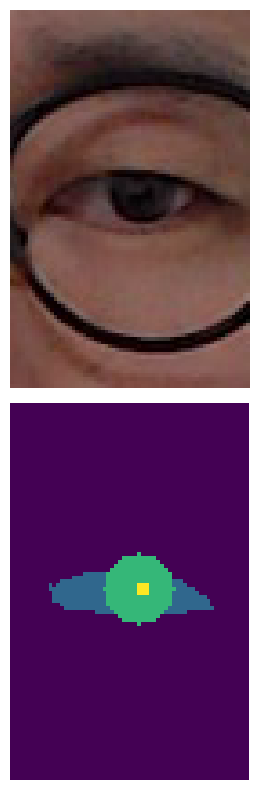

In [76]:
ncropped, nmask = mask_one_eye(np.array(img), eye, "l")
fig, axs = plt.subplots(2,1, figsize=(3,8))
axs[0].imshow(cropped)
axs[1].imshow(nmask)
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.savefig("left_eye_mask_inf.png")

In [ ]:
eye.r_eyelid['points'] = [[960, 264],
                         [963, 265],
                         [968, 266],
                         [975, 267],
                         [983, 268],
                         [990, 268],
                         [995, 268],
                         [998, 266],
                         [1002, 264],
                         [1001, 262],
                         [997, 260],
                         [993, 258],
                         [985, 257],
                         [978, 256],
                         [970, 259],
                         [963, 263]]

In [80]:
eye.r_iris['cx'] = 983
eye.r_iris['ry'] = 10

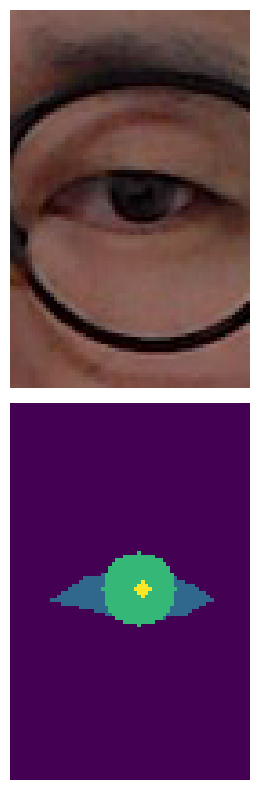

In [81]:
ncropped, nmask = mask_one_eye(np.array(img), eye, "r")
fig, axs = plt.subplots(2,1, figsize=(3,8))
axs[0].imshow(cropped)
axs[1].imshow(nmask)
for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.savefig("right_eye_mask_inf.png")

# Evaluate model

In [62]:
import torch
import os
import ritnet
from ritnet.dataset import IrisDataset, transform
from torch.utils.data import DataLoader 
from ritnet.opt import parse_args
from ritnet.models import model_dict
from ritnet.utils import get_predictions
from ritnet.dataset import MaskToTensor

In [60]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

model = model_dict['densenet']
model  = model.to(device)
filename = '../../RITnet/best_model_previous.pkl'

In [61]:
model.load_state_dict(torch.load(filename))
model = model.to(device)
model.eval()

DenseNet2D(
  (down_block1): DenseNet2D_down_block(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(33, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv31): Conv2d(65, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): AvgPool2d(kernel_size=None, stride=None, padding=0)
    (relu): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (dropout3): Dropout(p=0.2, inplace=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_block2): DenseNet2D_down_block(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=

In [64]:
img_tensor = MaskToTensor()(cropped)

In [66]:
img_tensor.shape

torch.Size([104, 66, 3])

In [67]:
model(img_tensor)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 104, 66, 3] to have 1 channels, but got 104 channels instead